In [341]:
%matplotlib inline
import torch as tc
import tensorflow as tf
import mxnet as mx
from mxnet import np as mxnp
from mxnet import npx as npx
npx.set_np()
# import numpy as np

from d2l import mxnet as mxd2l  # Use MXNet as the backend
from d2l import torch as tcd2l  # Use PyTorch as the backend
from d2l import tensorflow as tfd2l  # Use TensorFlow as the backend

tc.__version__,tf.__version__,mx.__version__

('1.6.0', '2.3.1', '1.7.0')

In [404]:
data_file_path=r'../data/cmn-eng/cmn_1.txt'
def read_data_nmt(path=data_file_path):
    with open(path,'r',encoding='utf-8') as f:
        next(f)
        return f.read()
raw_text = read_data_nmt()

In [406]:
def no_space(char, prev_char):
    #增加了符号 "'"，以便实现he's ——> he 和  's 两个token
    return char in set("',.!?") and prev_char != ' '  #set(',.!?，。！？')

In [407]:
def preprocess_nmt(raw_text):
    text=raw_text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    out=[' '+char if (i>0 and no_space(char,text[i-1])) else char for i,char in enumerate(text)]
    return ''.join(out)

In [408]:
text = preprocess_nmt(raw_text)

In [410]:
import re
def get_word_list(text):
    text=preprocess_nmt(text)
    res = re.compile(r"([\u4e00-\u9fa5，、。！？])")  # [\u4e00-\u9fa5]中文范围,以及中文符号“，、。！？”拆分
    p1 = res.split(text.lower())
    str_list = []
    for seg in p1:
        str_list=str_list+(seg.split(' '))
    list_word = [w for w in str_list if len(w.strip()) > 0]  # 去掉为空的字符
    return list_word

In [411]:
def tokenize_nmt(text,num_examples=None):
    zh_source,en_target=[],[]
    for i,line in enumerate(text.split('\n')):
        if num_examples is not None and i>num_examples:
            break
#         print(i,line)
        parts=line.split('\t')
        if len(parts)==2:
            zh_source.append(get_word_list(parts[1]))
            en_target.append(get_word_list(parts[0]))
#             zh_source.append(list(parts[1]))
#             en_target.append(parts[0].split(' '))
    return zh_source,en_target

In [412]:
zh_source,en_target = tokenize_nmt(raw_text)

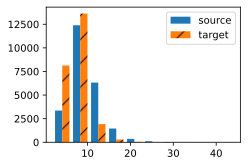

In [419]:
d2l=mxd2l
d2l.set_figsize()
_, _, patches = d2l.plt.hist(
    [[len(l) for l in zh_source], [len(l) for l in en_target]],
    label=['source', 'target'])
for patch in patches[1].patches:
    patch.set_hatch('/')
d2l.plt.legend(loc='upper right');

In [420]:
src_vocab = d2l.Vocab(zh_source, min_freq=2,reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

2898

In [421]:
tgt_vocab = d2l.Vocab(en_target, min_freq=2,reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(tgt_vocab)

4125

In [427]:
def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))  # Pad

truncate_pad(src_vocab[zh_source[0]], 10, src_vocab['<pad>'])

[1978, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [428]:
src_vocab.to_tokens([1978, 4, 1, 1, 1, 1, 1, 1, 1, 1])

['嗨',
 '。',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']

In [431]:
def build_array_nmt(lines, vocab, num_steps):
    """Transform text sequences of machine translation into minibatches."""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = np.array([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = d2l.reduce_sum(
        d2l.astype(array != vocab['<pad>'], np.int32), 1)
    return array, valid_len

In [432]:
#@save
np=mxnp
def load_data_nmt(batch_size, num_steps, num_examples=None):
    """Return the iterator and the vocabularies of the translation dataset."""
    # text = preprocess_nmt(read_data_nmt()) 
    # 上面的语句放到 tokenize_nmt 方法中了，
    source, target = tokenize_nmt(text, num_examples) # 调用到get_word_list方法
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab,source, target

In [433]:
train_iter, src_vocab, tgt_vocab,source, target = load_data_nmt(batch_size=2, num_steps=12)

In [434]:
len(source),len(target)

(24026, 24026)

In [435]:
source[0:10],target[0:10]

([['嗨', '。'],
  ['你', '好', '。'],
  ['你', '用', '跑', '的', '。'],
  ['等', '等', '！'],
  ['等', '一', '下', '！'],
  ['你', '好', '。'],
  ['我', '赢', '了', '。'],
  ['不', '会', '吧', '。'],
  ['乾', '杯', '!'],
  ['你', '懂', '了', '吗', '？']],
 [['hi', '.'],
  ['hi', '.'],
  ['run', '.'],
  ['wait', '!'],
  ['wait', '!'],
  ['hello', '!'],
  ['i', 'won', '!'],
  ['oh', 'no', '!'],
  ['cheers', '!'],
  ['got', 'it', '?']])

In [436]:
i=0
for X, X_valid_len, Y, Y_valid_len in train_iter:
  
    X=X.astype(np.int32).asnumpy()
    Y=Y.astype(np.int32).asnumpy()
    
#     print('X:', X.astype(np.int32))    
#     print('valid lengths for X:', X_valid_len)    
#     print('Y:', Y.astype(np.int32))
#     print('valid lengths for Y:', Y_valid_len)
    print("---"*30)
    print(src_vocab.to_tokens(list(X[0])),tgt_vocab.to_tokens(list(Y[0])))
    print(src_vocab.to_tokens(list(X[1])),tgt_vocab.to_tokens(list(Y[1])))
    print("---"*30)
    i+=1
    if i==5:
        break

------------------------------------------------------------------------------------------
['我', '們', '也', '幫', '助', '他', '們', '。', '<eos>', '<pad>', '<pad>', '<pad>'] ['we', 'helped', 'them', 'as', 'well', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['我', '打', '算', '與', '她', '分', '手', '。', '<eos>', '<pad>', '<pad>', '<pad>'] ['i', 'plan', 'to', 'break', 'up', 'with', 'her', '.', '<eos>', '<pad>', '<pad>', '<pad>']
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
['根', '據', '報', '導', '，', '昨', '晚', '有', '一', '場', '很', '大'] ['"according', 'to', 'the', 'newspaper', ',', 'there', 'was', 'a', 'big', 'fire', 'last', 'night']
['在', '假', '期', '中', '我', '什', '麼', '都', '沒', '有', '做', '。'] ['i', 'didn', "'t", 'do', 'anything', 'during', 'my', 'vacation', '.', '<eos>', '<pad>', '<pad>']
-----------------------------------------------------------------

In [437]:
src_vocab.token_freqs 

[('。', 20318),
 ('我', 10738),
 ('的', 7102),
 ('了', 5225),
 ('你', 5016),
 ('他', 4265),
 ('不', 3326),
 ('是', 3284),
 ('一', 3147),
 ('？', 3081),
 ('在', 3067),
 ('有', 2515),
 ('姆', 2411),
 ('她', 1869),
 ('，', 1562),
 ('汤', 1547),
 ('很', 1541),
 ('要', 1533),
 ('這', 1448),
 ('人', 1409),
 ('这', 1349),
 ('們', 1313),
 ('天', 1280),
 ('到', 1258),
 ('去', 1227),
 ('上', 1214),
 ('個', 1187),
 ('个', 1147),
 ('们', 1139),
 ('想', 1136),
 ('好', 1079),
 ('什', 1077),
 ('那', 1076),
 ('能', 1026),
 ('么', 1008),
 ('子', 987),
 ('嗎', 982),
 ('看', 927),
 ('做', 905),
 ('湯', 879),
 ('吗', 846),
 ('得', 836),
 ('多', 827),
 ('下', 776),
 ('道', 741),
 ('麼', 721),
 ('生', 716),
 ('会', 709),
 ('知', 700),
 ('會', 696),
 ('可', 690),
 ('都', 686),
 ('没', 684),
 ('来', 679),
 ('以', 667),
 ('裡', 666),
 ('喜', 653),
 ('來', 634),
 ('大', 627),
 ('把', 620),
 ('家', 617),
 ('事', 603),
 ('起', 556),
 ('就', 552),
 ('沒', 543),
 ('说', 539),
 ('时', 524),
 ('作', 517),
 ('和', 496),
 ('吃', 495),
 ('里', 484),
 ('为', 479),
 ('為', 474),
 ('本', 472),
 

In [440]:
tgt_vocab["'s"]

17

In [438]:
tgt_vocab.token_freqs

[('.', 19414),
 ('i', 6607),
 ('the', 5723),
 ('to', 4846),
 ('you', 4686),
 ('a', 3746),
 ('?', 3323),
 ('is', 3273),
 ("'t", 2581),
 ('he', 2528),
 ('tom', 2504),
 ('in', 1769),
 ('it', 1763),
 ("'s", 1743),
 ('of', 1661),
 ('my', 1455),
 ('that', 1434),
 ('she', 1386),
 ('this', 1364),
 ('me', 1345),
 (',', 1332),
 ('do', 1323),
 ('have', 1309),
 ('was', 1231),
 ('for', 1171),
 ('we', 1094),
 ('."', 1049),
 ('what', 988),
 ('don', 966),
 ('are', 957),
 ('can', 952),
 ('your', 952),
 ('on', 915),
 ('his', 857),
 ('at', 820),
 ('like', 791),
 ("'m", 767),
 ('be', 744),
 ('with', 706),
 ('not', 699),
 ('there', 632),
 ('go', 609),
 ('her', 582),
 ('know', 553),
 ('want', 553),
 ('and', 552),
 ('has', 541),
 ('will', 536),
 ('how', 528),
 ('him', 521),
 ('very', 513),
 ("'ll", 480),
 ('they', 465),
 ('as', 452),
 ('time', 445),
 ('here', 441),
 ('did', 439),
 ('please', 435),
 ('all', 426),
 ('up', 412),
 ('good', 391),
 ('think', 383),
 ('an', 377),
 ('mary', 377),
 ("'ve", 375),
 ('ab